In [ ]:
# default_exp exp.info-[inspect]

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [2]:
! pip install -e . #to install an edible version of the ds4se lib please run it on the root

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /Users/yangchen/Desktop/ds4se/nbs
You should consider upgrading via the '/System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python -m pip install --upgrade pip' command.


# Exploration of your data using Information Theory

> This module comprises all functions for running a proper exploratory analysis using Information Theory.

In [11]:
# export
# Imports
import dit
import math
import os
import logging

import matplotlib.pyplot as plt
import pandas as pd
import sentencepiece as sp

from collections import Counter
from pathlib import Path
from scipy.stats import sem, t
from statistics import mean, median, stdev
from tqdm.notebook import tqdm
import functools

In [12]:
import ds4se as ds

ModuleNotFoundError: No module named 'ds4se'

In [10]:
# ds4se
from ds4se.mgmnt.prep.bpe import *

ModuleNotFoundError: No module named 'ds4se'

In [ ]:
#hide
from nbdev.showdoc import *
from ds4se.desc.stats import *

In [ ]:
# export
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix

In [ ]:
#export
logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )

In [ ]:
#hide
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo(path):
    corpus_data = {'file_name': [], 'data_type': [], 'contents': []}
    req_path = path / "requirements"
    for file in os.listdir(req_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('req')
        with open (os.path.join(req_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    src_path = path / "source_code"
    for file in os.listdir(src_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('src')
        with open (os.path.join(src_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    tst_path = path / "test"
    for file in os.listdir(tst_path):
        corpus_data['file_name'].append(file)
        corpus_data['data_type'].append('test')
        with open (os.path.join(tst_path, file), "r") as f:
            corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [ ]:
# export
def get_cnts(toks, vocab):
    '''@danaderp
    Counts tokens within ONE document'''
    #logging.info("encoding_size:" len
    cnt = Counter(vocab)
    for tok in toks:
        cnt[tok] += 1
            
    return cnt

In [ ]:
# export
def encode_text(text, model_prefix):
    '''@danaderp
    Encodes text using a pre-trained sp model, returns the occurrences of each token in the text'''
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    encoding = sp_processor.encode_as_pieces(text)
    
    vocab = {sp_processor.id_to_piece(id): 0 for id in range(sp_processor.get_piece_size())}
    token_counts = get_cnts(encoding, vocab)
    return token_counts

In [ ]:
# export
def get_freqs(dict_token_counts):
    
    num_tokens = sum( dict_token_counts.values() ) #number of subwords inside the document
    frequencies = [ (dict_token_counts[token])/num_tokens for token in dict_token_counts ]
    
    return frequencies

In [ ]:
# export
def get_dist(token_counts):
    '''@danaderp
    Takes in a counter object of token occurrences, computes the entropy of the corpus that produced it'''
    alphabet = list(set(token_counts.keys()))
    frequencies = get_freqs(token_counts)
#     for token in token_counts:s
#         frequencies.append((token_counts[token])/num_tokens)
#     logging.info(f'alphabet size {len(alphabet)}, freq size {len(frequencies)} alphabet - {list(token_counts.keys())}')
    return dit.ScalarDistribution(alphabet, frequencies)

In [ ]:
# export
def get_entropies_from_docs(docs, vocab):
    entropies = []
    for doc in tqdm(docs):
        token_counts = get_cnts(doc, vocab)
        entropies.append(dit.shannon.entropy(get_dist(token_counts)))
    
    return entropies

In [ ]:
# export
def get_entropy_from_docs(docs, vocab):
    entropies = []
    token_counts = Counter(vocab)
    for doc in tqdm(docs):
        token_counts += get_cnts(doc, vocab)
        
    return dit.shannon.entropy(get_dist(token_counts))

In [ ]:
# export
def get_doc_entropies_from_df(df, col, model_path, data_types):
    '''Returns a list of the entropies of each entry in a dataframe column'''
    all_entropies = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        entropies = []
        for data in corpus[col]:
            token_counts= encode_text(data, model_path)
            entropies.append(dit.shannon.entropy(get_dist(token_counts)))
        
        all_entropies.append(entropies)
            
    return all_entropies

In [ ]:
# export
def get_corpus_entropies_from_df(df, col, model_path, data_types):
    entropies = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        token_counts = Counter()
        for data in corpus[col]:
            token_counts += encode_text(data, model_path)
        entropies.append(dit.shannon.entropy(get_dist(token_counts)))
        
    return entropies

In [ ]:
# export
def get_system_entropy_from_df(df, col, model_path):
    token_counts = Counter()
    for data in df[col]:
        token_counts += encode_text(data, model_path)
        
    return dit.shannon.entropy(get_dist(token_counts))

## CISCO Unsupervised Analysis

In [ ]:
from ds4se.mining.unsupervised.traceability.approach.cisco import *
from ds4se.mgmnt.prep.conv import *

In [ ]:
path_to_trained_model = 'test_data/models/wv/bpe128k/[word2vec-Java-Py-SK-500-20E-128k-1594873397.267055].model'

In [ ]:
def libest_params_bpe():
        return {
        "vectorizationType": VectorizationType.word2vec,
        "linkType": LinkType.req2src,
        "system": 'libest',
        "path_to_trained_model": path_to_trained_model,
        "source_type": 'req', #TODO Standardize the artifacts 
        "target_type": 'tc',
        #"path_mappings": 'cisco/libest_data/sacp-pr-mappings.csv',
        "system_path_config": {
            "system_path": 'cisco/libest_data/[libest-all-corpus-1596063103.098236].csv',
            "sep": '~',
            "names": ['ids','bpe128k'],
            "prep": Preprocessing.bpe
        },
        "saving_path": 'cisco/libest_data/',
        "names": ['Source','Target','Linked?'],
        "model_prefix":'test_data/sentencepiece/wiki_py_java_bpe_128k' #For BPE Analysis
    }

In [ ]:
def sacp_params_bpe():
        return {
        "vectorizationType": VectorizationType.word2vec,
        "linkType": LinkType.issue2src,
        "system": 'sacp-python-common',
        "path_to_trained_model": path_to_trained_model,
        "source_type": 'pr', #TODO Standardize the artifacts 
        "target_type": 'py',
        #"path_mappings": 'cisco/libest_data/sacp-pr-mappings.csv',
        "system_path_config": {
            "system_path": 'cisco/sacp_data/[sacp-python-common-all-corpus-1595953540.866044].csv',
            "sep": '~',
            "names": ['ids','bpe128k'],
            "prep": Preprocessing.bpe
        },
        "saving_path": 'cisco/sacp_data/',
        "names": ['Source','Target','Linked?'],
        "model_prefix":'test_data/sentencepiece/wiki_py_java_bpe_128k' #For BPE Analysis
    }

In [ ]:
#parameters = libest_params_bpe()
parameters = sacp_params_bpe()

In [ ]:
prep = ConventionalPreprocessing(parameters, bpe = True)

In [ ]:
#Preprocessed Dataset Loading
#[libest-all-corpus-1596063103.098236].csv
#df_all_dataset = prep.LoadCorpus(1596063103.098236,language='all-corpus', sep='~')
df_all_dataset = prep.LoadCorpus(1595953540.866044,language='all-corpus', sep='~')

In [ ]:
df_all_dataset

,ids,text,type,conv,bpe128k
0,295,Production Merge * Feed release name through t...,pr,product merg feed releas name upload bom allow...,"[▁production, ▁merge, ▁*, ▁feed, ▁release, ▁na..."
1,294,Add test fields for DARE push * Added test dat...,pr,add test field dare push test data json sent d...,"[▁add, ▁test, ▁fields, ▁for, ▁dare, ▁push, ▁*,..."
2,293,"Allow passing a release to uploadBom by name, ...",pr,allow pass releas upload bom name rather chang...,"[▁allow, ▁passing, ▁a, ▁release, ▁to, ▁upload,..."
3,287,Allow append images #363 - Changed how image n...,pr,allow append imag chang imag name creat send c...,"[▁allow, ▁append, ▁images, ▁#3, 63, ▁-, ▁chang..."
4,274,Move docker/blackduck test to slave 4,pr,move docker blackduck test slave,"[▁move, ▁docker, /, black, duck, ▁test, ▁to, ▁..."
...,...,...,...,...,...
92,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...,"[▁import, ▁os, \r\n, import, ▁un, itt, est, \r..."
93,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...,"[▁import, ▁os, \r\n, import, ▁un, itt, est, \r..."
94,sacp-python-common/test/python/third_party/tes...,import unittest\r\nfrom unittest import mock\r...,py,import unittest unittest import mock unittest ...,"[▁import, ▁un, itt, est, \r\n, from, ▁un, itt,..."
95,sacp-python-common/test/python/third_party/unu...,# import json\r\n# import unittest\r\n# from u...,py,import json import unittest unittest import mo...,"[▁#, ▁import, ▁json, \r\n, #, ▁import, ▁un, it..."


In [ ]:
df_all_dataset['text'].fillna(' ', inplace = True) #Filling Nan Values

In [ ]:
df_all_dataset.dropna( inplace = True ) #empty files are not considered

In [ ]:
df_all_dataset[df_all_dataset.text.notnull()]

,ids,text,type,conv
0,295,Production Merge * Feed release name through t...,pr,product merg feed releas name upload bom allow...
1,294,Add test fields for DARE push * Added test dat...,pr,add test field dare push test data json sent d...
2,293,"Allow passing a release to uploadBom by name, ...",pr,allow pass releas upload bom name rather chang...
3,287,Allow append images #363 - Changed how image n...,pr,allow append imag chang imag name creat send c...
4,274,Move docker/blackduck test to slave 4,pr,move docker blackduck test slave
...,...,...,...,...
92,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...
93,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...
94,sacp-python-common/test/python/third_party/tes...,import unittest\r\nfrom unittest import mock\r...,py,import unittest unittest import mock unittest ...
95,sacp-python-common/test/python/third_party/unu...,# import json\r\n# import unittest\r\n# from u...,py,import json import unittest unittest import mo...


In [ ]:
df_all_dataset['text'].values[:2]

array(['Production Merge * Feed release name through to uploadBom (#293  ) * Allow append images (#287 ) * DARE test fields (#294)',
       'Add test fields for DARE push * Added test data to the JSON being sent to DARE when running static code analysis. Example psb data below. Closes SACP/CSB-CICDPipelineEdition#381 * Added 2 additional scf mappings * [Test builds](https://engci-jenkins-rtp.cisco.com/jenkins/job/team_SACP/job/dev_jobs/job/kybaek/job/sec-res-push/)  ```       {          "req_id":"SEC-VAL-INSQL-2",          "status":"partial pass",          "output":{             "description":"SpotBugs: No High, Medium, or Low Severity Errors found in the assets scanned."          },          "assets_tested":[             {                "name":"/csb-cicd/static-scan/temp/Artifacts/helloworld.jar"             }          ],          "test":{             "test_name":"PATH_TRAVERSAL_IN, XSS_SERVLET, UNVALIDATED_REDIRECT, URL_REWRITING, INSECURE_COOKIE, WEAK_MESSAGE_DIGEST_MD5, UNSAFE_HAS

In [ ]:
prep.bpe_pieces_pipeline( df_all_dataset['text'].values[:2] )

[['▁production',
  '▁merge',
  '▁*',
  '▁feed',
  '▁release',
  '▁name',
  '▁through',
  '▁to',
  '▁upload',
  'bom',
  '▁(#',
  '293',
  '▁)',
  '▁*',
  '▁allow',
  '▁append',
  '▁images',
  '▁(#',
  '287',
  '▁)',
  '▁*',
  '▁dare',
  '▁test',
  '▁fields',
  '▁(#',
  '29',
  '4)'],
 ['▁add',
  '▁test',
  '▁fields',
  '▁for',
  '▁dare',
  '▁push',
  '▁*',
  '▁added',
  '▁test',
  '▁data',
  '▁to',
  '▁the',
  '▁json',
  '▁being',
  '▁sent',
  '▁to',
  '▁dare',
  '▁when',
  '▁running',
  '▁static',
  '▁code',
  '▁analysis',
  '.',
  '▁example',
  '▁psb',
  '▁data',
  '▁below',
  '.',
  '▁closes',
  '▁sac',
  'p',
  '/',
  'csb',
  '-',
  'cic',
  'dp',
  'ip',
  'eline',
  'edition',
  '#',
  '381',
  '▁*',
  '▁added',
  '▁2',
  '▁additional',
  '▁sc',
  'f',
  '▁m',
  'appings',
  '▁*',
  '▁[',
  'test',
  '▁builds',
  ']',
  '(',
  'https',
  '://',
  'eng',
  'ci',
  '-',
  'jen',
  'kins',
  '-',
  'rt',
  'p',
  '.',
  'c',
  'isco',
  '.',
  'com',
  '/',
  'jen',
  'kins',
  '/'

In [ ]:
df_all_dataset['bpe128k'] = prep.bpe_pieces_pipeline( df_all_dataset['text'].values ) #BPE Preprocessing

In [ ]:
def compute_entropy_extropy_eval( df_corpus, prep, columns=['bpe128k','bpe32k','bpe8k'] ): # TODOinclude the conv analysis later
    """@danaderp
    df_all_corpus: a pandas with all the corpus and preprocessed data
    prep: a preprocessor for conventiona and bpe
    columns: the name of the columns to be processed """
    df_all_corpus = df_corpus.copy()
    
    for corpus in columns:
        if corpus == 'conv':
            #TODO This analysis needs the word2vec sequence vectorization object for the vocabulary
            artifact_pre = [  art.split()  for art in df_all_corpus[ corpus ].values ] #tst
            abstracted_vocab = [ set(doc.split()) for doc in df_all_dataset[ corpus ].values] #creation of sets
            abstracted_vocab = functools.reduce( lambda a,b : a.union(b), abstracted_vocab ) #union of sets
        else:
            artifact_pre = [ eval( art ) for art in df_all_corpus[ corpus ].values ] #tst
            logging.info('artifact_pre loaded')
            
            abstracted_vocab = [ set(eval(doc)) for doc in df_all_dataset[ corpus ].values] #creation of sets
            abstracted_vocab = functools.reduce( lambda a,b : a.union(b), abstracted_vocab ) #union of sets
            vocab = {prep.sp_bpe.id_to_piece(id): 0 for id in range(prep.sp_bpe.get_piece_size())}
            dict_abs_vocab = { elem : 0 for elem in abstracted_vocab - set(vocab.keys()) } #Ignored vocab by BPE
            vocab.update(dict_abs_vocab) #Updating
            logging.info('vocab updated')
            
            token_counts = [ get_cnts(art, vocab) for art in artifact_pre ]
            logging.info('token count processed')
            
            alphabet = [ list(set(cnt.keys())) for cnt in token_counts ]
            frequencies = [ get_freqs(cnt) for cnt in token_counts ]
            logging.info('frequencies processed')
            
            scalar_distribution = [dit.ScalarDistribution(alphabet[id], frequencies[id]) for id in range( len(token_counts) )]
            logging.info('scalar_distribution processed')
            
            entropies = [ dit.shannon.entropy( dist ) for dist in scalar_distribution ]
            logging.info('entropies processed')
            
            extropies = [ dit.other.extropy( dist ) for dist in scalar_distribution ]
            logging.info('extropies processed')
            
            df_all_corpus[corpus+'_I'] = entropies
            df_all_corpus[corpus+'_X'] = extropies
    return df_all_corpus
    

In [ ]:
#without eval
def compute_entropy_extropy( df_corpus, prep, columns=['bpe128k','bpe32k','bpe8k'] ): # TODOinclude the conv analysis later
    """@danaderp
    df_all_corpus: a pandas with all the corpus and preprocessed data
    prep: a preprocessor for conventiona and bpe
    columns: the name of the columns to be processed """
    df_all_corpus = df_corpus.copy()
    
    for corpus in columns:
        if corpus == 'conv':
            #TODO This analysis needs the word2vec sequence vectorization object for the vocabulary
            artifact_pre = [  art.split()  for art in df_all_corpus[ corpus ].values ] #tst
            abstracted_vocab = [ set(doc.split()) for doc in df_all_dataset[ corpus ].values] #creation of sets
            abstracted_vocab = functools.reduce( lambda a,b : a.union(b), abstracted_vocab ) #union of sets
        else:
            artifact_pre = [  art  for art in df_all_corpus[ corpus ].values ] #tst
            logging.info('artifact_pre loaded')
            
            abstracted_vocab = [ set(doc) for doc in df_all_dataset[ corpus ].values] #creation of sets
            abstracted_vocab = functools.reduce( lambda a,b : a.union(b), abstracted_vocab ) #union of sets
            vocab = {prep.sp_bpe.id_to_piece(id): 0 for id in range(prep.sp_bpe.get_piece_size())}
            dict_abs_vocab = { elem : 0 for elem in abstracted_vocab - set(vocab.keys()) } #Ignored vocab by BPE
            vocab.update(dict_abs_vocab) #Updating
            logging.info('vocab updated')
            
            token_counts = [ get_cnts(art, vocab) for art in artifact_pre ]
            logging.info('token count processed')
            
            alphabet = [ list(set(cnt.keys())) for cnt in token_counts ]
            frequencies = [ get_freqs(cnt) for cnt in token_counts ]
            logging.info('frequencies processed')
            
            scalar_distribution = [dit.ScalarDistribution(alphabet[id], frequencies[id]) for id in range( len(token_counts) )]
            logging.info('scalar_distribution processed')
            
            entropies = [ dit.shannon.entropy( dist ) for dist in scalar_distribution ]
            logging.info('entropies processed')
            
            extropies = [ dit.other.extropy( dist ) for dist in scalar_distribution ]
            logging.info('extropies processed')
            
            df_all_corpus[corpus+'_I'] = entropies
            df_all_corpus[corpus+'_X'] = extropies
    return df_all_corpus

In [ ]:
df_energy_model = compute_entropy_extropy(df_all_dataset,prep,columns=['bpe128k'])

2020-08-02 04:29:28,213 : INFO : artifact_pre loaded
2020-08-02 04:29:28,363 : INFO : vocab updated
2020-08-02 04:29:31,254 : INFO : token count processed
2020-08-02 04:29:48,906 : INFO : frequencies processed


In [ ]:
prep.SaveCorpus(df_energy_model, language='df_energy_model', sep='~')

2020-08-03 04:21:41,958 : INFO : Saving in...cisco/sacp_data/[sacp-python-common-df_energy_model-1596428501.900477].csv


In [ ]:
prep.sp_bpe.get_piece_size()

In [ ]:
df_energy_model

,ids,text,type,conv,bpe128k,bpe128k_I,bpe128k_X
0,295,Production Merge * Feed release name through t...,pr,product merg feed releas name upload bom allow...,"[▁production, ▁merge, ▁*, ▁feed, ▁release, ▁na...",4.328600,1.401088
1,294,Add test fields for DARE push * Added test dat...,pr,add test field dare push test data json sent d...,"[▁add, ▁test, ▁fields, ▁for, ▁dare, ▁push, ▁*,...",6.767840,1.430056
2,293,"Allow passing a release to uploadBom by name, ...",pr,allow pass releas upload bom name rather chang...,"[▁allow, ▁passing, ▁a, ▁release, ▁to, ▁upload,...",6.253959,1.430591
3,287,Allow append images #363 - Changed how image n...,pr,allow append imag chang imag name creat send c...,"[▁allow, ▁append, ▁images, ▁#3, 63, ▁-, ▁chang...",6.111571,1.429240
4,274,Move docker/blackduck test to slave 4,pr,move docker blackduck test slave,"[▁move, ▁docker, /, black, duck, ▁test, ▁to, ▁...",3.169925,1.359400
...,...,...,...,...,...,...,...
92,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...,"[▁import, ▁os, \r\n, import, ▁un, itt, est, \r...",6.361701,1.426202
93,sacp-python-common/test/python/third_party/tes...,import os\r\nimport unittest\r\n\r\nfrom param...,py,import import unittest parameter import parame...,"[▁import, ▁os, \r\n, import, ▁un, itt, est, \r...",6.624613,1.422084
94,sacp-python-common/test/python/third_party/tes...,import unittest\r\nfrom unittest import mock\r...,py,import unittest unittest import mock unittest ...,"[▁import, ▁un, itt, est, \r\n, from, ▁un, itt,...",6.257173,1.419286
95,sacp-python-common/test/python/third_party/unu...,# import json\r\n# import unittest\r\n# from u...,py,import json import unittest unittest import mo...,"[▁#, ▁import, ▁json, \r\n, #, ▁import, ▁un, it...",6.111908,1.417350


### Statistical Analysis

In [ ]:
energy_metrics = ['bpe128k_I','bpe128k_X']

In [ ]:
df_energy_model[df_energy_model['type']=='py'][energy_metrics].describe()

,bpe128k_I,bpe128k_X
count,74.000000,74.000000
mean,6.419227,1.422485
std,0.536251,0.006657
min,3.803509,1.380234
25%,6.114249,1.419549
50%,6.401065,1.423157
75%,6.765780,1.426379
max,7.381581,1.431269


In [ ]:
df_energy_model[df_energy_model['type']=='pr'][energy_metrics].describe()

,bpe128k_I,bpe128k_X
count,288.000000,288.000000
mean,3.944652,1.338466
std,1.543730,0.185399
min,0.000000,0.000000
25%,2.807355,1.334355
50%,4.157343,1.394853
75%,5.094254,1.417582
max,7.358238,1.435389


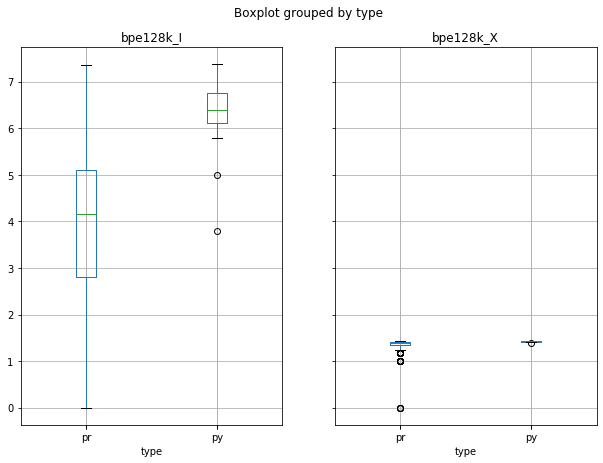

In [ ]:
boxplot = df_energy_model.boxplot(by='type',column=energy_metrics,figsize=[10, 7])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb38c637550>,
      dtype=object)

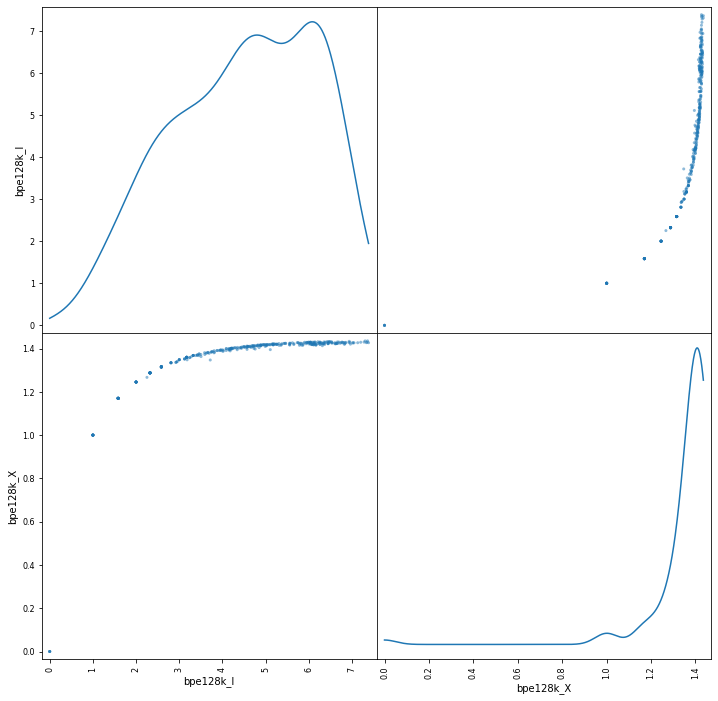

In [ ]:
scatter_matrix(df_energy_model[energy_metrics], alpha=0.5, figsize=(12, 12), diagonal='kde') #Analysis for the entire corpus

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0570e4b00>,
      dtype=object)

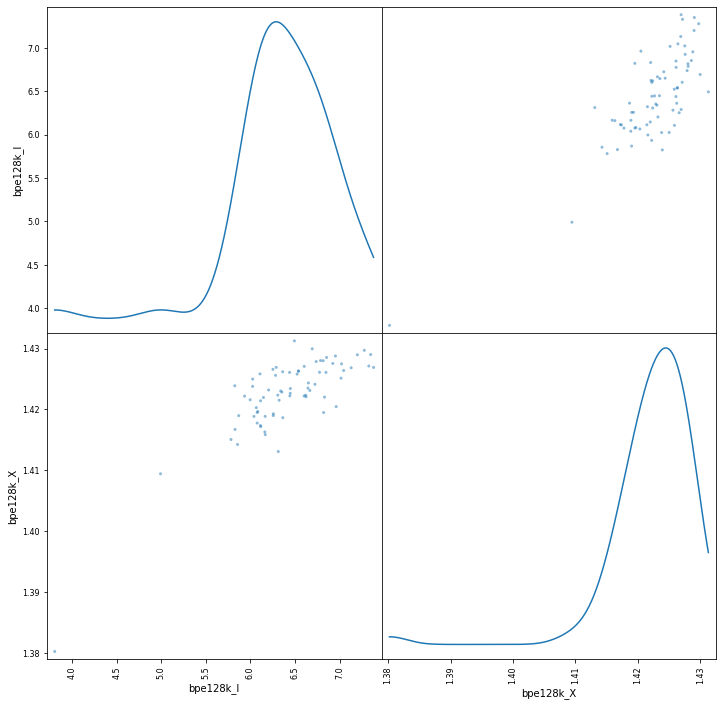

In [ ]:
scatter_matrix(df_energy_model[df_energy_model['type']=='py'][energy_metrics], alpha=0.5, figsize=(12, 12), diagonal='kde') #Analysis for the entire corpus

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1f3cdea20>,
      dtype=object)

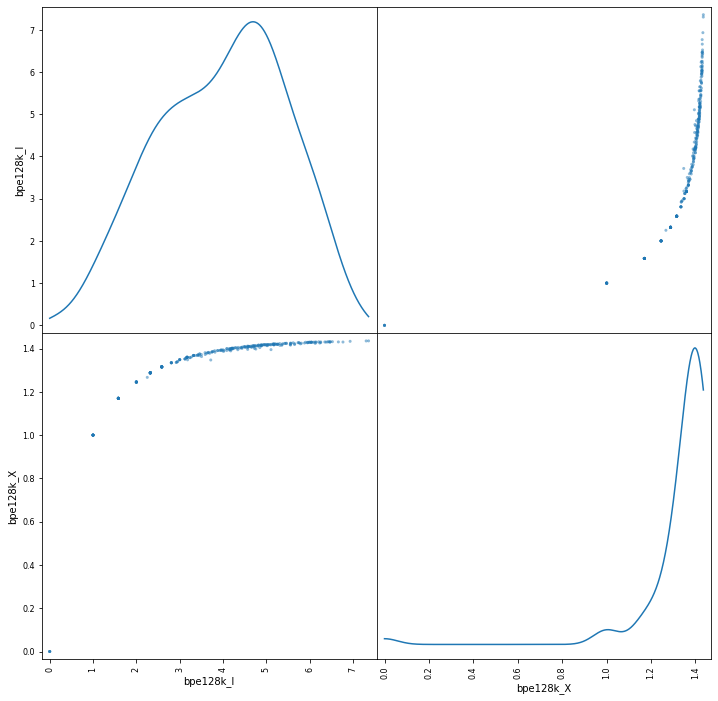

In [ ]:
scatter_matrix(df_energy_model[df_energy_model['type']=='pr'][energy_metrics], alpha=0.5, figsize=(12, 12), diagonal='kde') #Analysis for the entire corpus

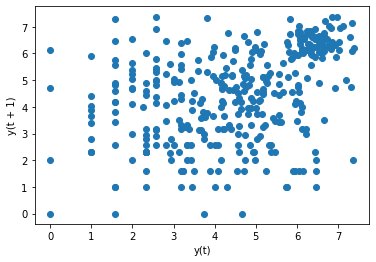

In [ ]:
lag_plot(df_energy_model['bpe128k_I'])

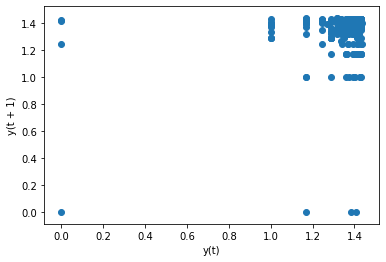

In [ ]:
lag_plot(df_energy_model['bpe128k_X'])

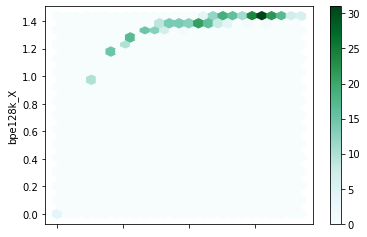

In [ ]:
df_energy_model.plot.hexbin(x='bpe128k_I', y='bpe128k_X', gridsize=25)

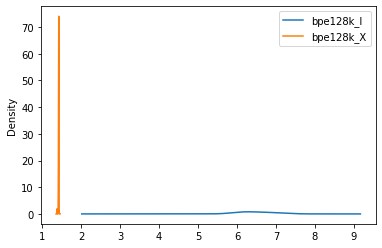

In [ ]:
df_energy_model[df_energy_model['type']=='py'][energy_metrics].plot.kde()

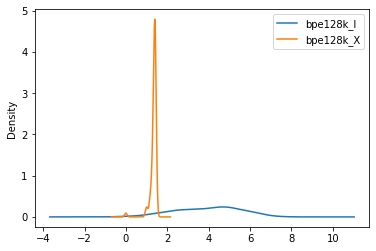

In [ ]:
df_energy_model[df_energy_model['type']=='pr'][energy_metrics].plot.kde()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1f370deb8>,
      dtype=object)

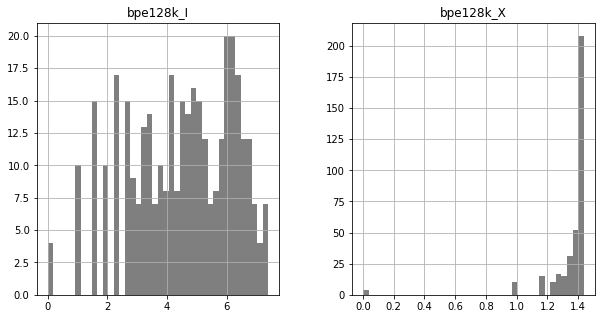

In [ ]:
df_energy_model.hist(column=energy_metrics,color='k',bins=40,figsize=[10,5],alpha=0.5)

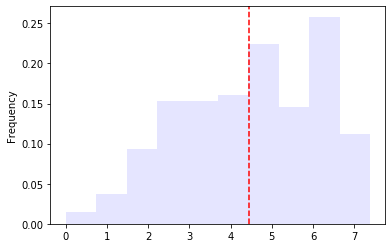

In [ ]:
fig, ax = plt.subplots()
df_energy_model['bpe128k_I'].plot.hist(density=True, color='blue', alpha=0.1, ax=ax) # Histogram will now be normalized
ax.axvline(df_energy_model['bpe128k_I'].mean(), color='red', linestyle='--') #df_energy_model[df_energy_model['type']=='py'][bpe128k_I]

In [ ]:
df_energy_model['bpe128k_I'].mean()

4.450504114015934

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb856139550>,
      dtype=object)

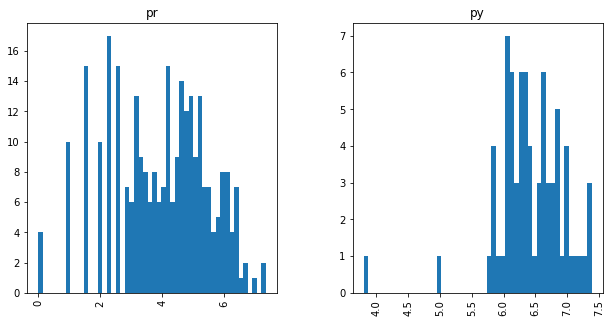

In [ ]:
df_energy_model.hist(by='type',column='bpe128k_I' ,figsize=[10, 5],bins=50)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8567e0978>,
      dtype=object)

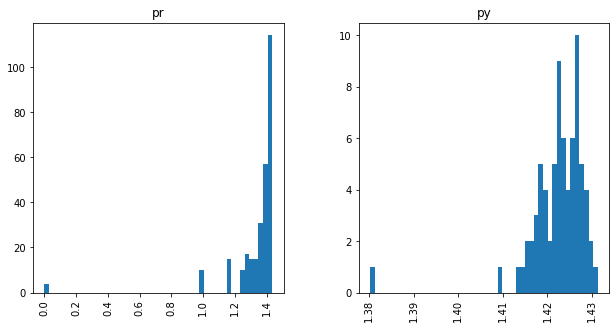

In [ ]:
df_energy_model.hist(by='type',column='bpe128k_X' ,figsize=[10, 5],bins=50)

### Testing Approach Down 

In [ ]:
prep.sp_bpe.get_piece_size()

128000

In [ ]:
artifact_pre = eval(df_all_dataset['bpe128k'].values[2]) #tst

In [ ]:
df_all_dataset['bpe128k'].values[0]

['▁production',
 '▁merge',
 '▁*',
 '▁feed',
 '▁release',
 '▁name',
 '▁through',
 '▁to',
 '▁upload',
 'bom',
 '▁(#',
 '293',
 '▁)',
 '▁*',
 '▁allow',
 '▁append',
 '▁images',
 '▁(#',
 '287',
 '▁)',
 '▁*',
 '▁dare',
 '▁test',
 '▁fields',
 '▁(#',
 '29',
 '4)']

In [ ]:
#Getting the vocabulary
abstracted_vocab = [ set((doc)) for doc in df_all_dataset['bpe128k'].values] #creation of sets
abstracted_vocab = functools.reduce( lambda a,b : a.union(b), abstracted_vocab ) #union of sets

In [ ]:
len(abstracted_vocab)

3580

In [ ]:
vocab = {prep.sp_bpe.id_to_piece(id): 0 for id in range(prep.sp_bpe.get_piece_size())}

In [ ]:
vocab['@']

KeyError: '@'

In [ ]:
abstracted_vocab - set(vocab.keys())

{'\t',
 '\t\t',
 '\t\t\t\t',
 '\t\n',
 '\t\n\n',
 '\n',
 '\n\t',
 '\n\t\t',
 '\n\t\t\t',
 '\n\t\t\t\t',
 '\n\t\t\t\t\t',
 '\n\t\t\t\t\t\t',
 '\n\t\t\n',
 '\n\t\n',
 '\n\t\n\t',
 '\n\n',
 '\n\n\t',
 '\n\n\n',
 '\n\n\n\n',
 '\n\\',
 '@',
 '\\',
 '\\\n',
 '\\\\',
 '`',
 '~'}

In [ ]:
dict_abs_vocab = { elem : 0 for elem in abstracted_vocab - set(vocab.keys()) }

In [ ]:
dict_abs_vocab

{'\n\t\t': 0,
 '`': 0,
 '@': 0,
 '\n\t\t\t\t\t': 0,
 '\n\n\n': 0,
 '\t\n': 0,
 '\\\n': 0,
 '\n\t\n\t': 0,
 '\n\n\n\n': 0,
 '\n\n': 0,
 '\\': 0,
 '\t\t': 0,
 '\n\t': 0,
 '\n\t\t\t': 0,
 '\n': 0,
 '\n\t\n': 0,
 '\t\n\n': 0,
 '\n\t\t\t\t': 0,
 '\n\\': 0,
 '\n\t\t\n': 0,
 '~': 0,
 '\\\\': 0,
 '\t\t\t\t': 0,
 '\n\n\t': 0,
 '\n\t\t\t\t\t\t': 0,
 '\t': 0}

In [ ]:
vocab

{'<unk>': 0,
 '<s>': 0,
 '</s>': 0,
 '▁t': 0,
 '▁a': 0,
 'he': 0,
 'in': 0,
 'er': 0,
 '▁the': 0,
 'on': 0,
 '▁s': 0,
 '▁c': 0,
 'or': 0,
 'at': 0,
 're': 0,
 'an': 0,
 '▁w': 0,
 '▁o': 0,
 'en': 0,
 '▁b': 0,
 'ed': 0,
 'is': 0,
 '▁f': 0,
 '▁p': 0,
 '▁in': 0,
 'es': 0,
 'al': 0,
 'it': 0,
 'ar': 0,
 '▁m': 0,
 '▁of': 0,
 '▁an': 0,
 '▁d': 0,
 'ic': 0,
 'as': 0,
 'ro': 0,
 'ing': 0,
 '▁and': 0,
 '▁h': 0,
 '▁l': 0,
 'ion': 0,
 '▁to': 0,
 'il': 0,
 '▁n': 0,
 'un': 0,
 '▁re': 0,
 'le': 0,
 '▁1': 0,
 '▁g': 0,
 'ent': 0,
 'us': 0,
 '▁e': 0,
 'am': 0,
 'ur': 0,
 'ate': 0,
 'ol': 0,
 'om': 0,
 'el': 0,
 '▁(': 0,
 'ac': 0,
 'ad': 0,
 'ut': 0,
 'ory': 0,
 '▁th': 0,
 'st': 0,
 '▁st': 0,
 'et': 0,
 'iv': 0,
 '▁2': 0,
 '▁on': 0,
 'ers': 0,
 '▁for': 0,
 '▁was': 0,
 'ec': 0,
 'ir': 0,
 'ation': 0,
 '▁he': 0,
 'ig': 0,
 'ateg': 0,
 'id': 0,
 '▁categ': 0,
 '▁category': 0,
 'ot': 0,
 '▁is': 0,
 '▁as': 0,
 'ly': 0,
 'im': 0,
 '▁r': 0,
 'ay': 0,
 'ter': 0,
 '▁19': 0,
 'ch': 0,
 '▁j': 0,
 'ul': 0,
 '▁v': 0,
 

In [ ]:
len(vocab)

128026

In [ ]:
vocab.update(dict_abs_vocab) #Updating

In [ ]:
abstracted_vocab - set(vocab.keys()) #missing words in the encodings!

set()

In [ ]:
set(vocab.keys()) - abstracted_vocab #Words from other contexts but software artifacts one

{'iburton',
 '▁exter',
 'iband',
 '▁booby',
 'ther',
 '–1906)',
 'interest',
 'ulea',
 '▁enfor',
 '▁moniker',
 'inkai',
 '▁bounds',
 '▁armorial',
 'missive',
 '▁mł',
 '▁pathological',
 'abil',
 '▁gardo',
 '▁mangeshkar',
 '▁9.1',
 '▁kenpeitai',
 '▁vaccinations',
 'ilink',
 'oshinsky',
 '▁friederike',
 'ielo',
 '▁ment',
 'phidae',
 '▁łom',
 'čová',
 '▁thomason',
 'lık',
 '▁1910–1918',
 'fft',
 'üsseld',
 '▁blet',
 '▁sitter',
 '▁lemieux',
 '▁1902)',
 '▁hajjiabad',
 '▁whitewash',
 '▁dizz',
 '▁1917:',
 '▁melayu',
 '▁trivia',
 'streit',
 '▁50.4%',
 '▁96,',
 '▁1955',
 '▁feroc',
 '▁bento',
 'jacket',
 '▁kre',
 '▁pgs',
 '▁corral',
 '▁pancasila',
 'ocrat',
 '▁furse',
 '-26',
 'rama',
 '▁guayaquil',
 'libya',
 'organizations',
 'igating',
 'bak',
 '▁wagers',
 '▁towa',
 '▁carlsen',
 '▁confucius',
 'elap',
 'dynam',
 '▁millfield',
 'gotha',
 'wé',
 '▁embarking',
 'ifferent',
 '▁indie',
 'teddy',
 '▁librettos',
 '▁violent',
 '▁matriculated',
 'includes',
 'ecoregions',
 '▁imperatives',
 '▁outgrowth'

In [ ]:
token_counts = get_cnts(artifact_pre, vocab)

In [ ]:
token_counts

Counter({'<unk>': 0,
         '<s>': 0,
         '</s>': 0,
         '▁t': 2,
         '▁a': 106,
         'he': 0,
         'in': 25,
         'er': 64,
         '▁the': 167,
         'on': 1,
         '▁s': 1,
         '▁c': 96,
         'or': 0,
         'at': 24,
         're': 41,
         'an': 65,
         '▁w': 0,
         '▁o': 0,
         'en': 84,
         '▁b': 8,
         'ed': 16,
         'is': 10,
         '▁f': 25,
         '▁p': 18,
         '▁in': 41,
         'es': 6,
         'al': 31,
         'it': 20,
         'ar': 0,
         '▁m': 20,
         '▁of': 21,
         '▁an': 16,
         '▁d': 1,
         'ic': 4,
         'as': 1,
         'ro': 0,
         'ing': 14,
         '▁and': 10,
         '▁h': 0,
         '▁l': 2,
         'ion': 2,
         '▁to': 58,
         'il': 0,
         '▁n': 73,
         'un': 11,
         '▁re': 2,
         'le': 3,
         '▁1': 3,
         '▁g': 0,
         'ent': 1,
         'us': 85,
         '▁e': 7,
         'am': 0,
 

In [ ]:
alphabet = list(set(token_counts.keys()))
alphabet

['iburton',
 '▁exter',
 'iband',
 '▁booby',
 'ther',
 '–1906)',
 'interest',
 'ulea',
 '▁enfor',
 '▁moniker',
 'inkai',
 'aaaa',
 '▁bounds',
 '▁armorial',
 'missive',
 '▁mł',
 '▁pathological',
 'abil',
 '▁attempt',
 '▁gardo',
 '▁mangeshkar',
 '▁9.1',
 '▁kenpeitai',
 '▁vaccinations',
 'ilink',
 'oshinsky',
 '▁classes',
 '▁friederike',
 'ielo',
 '▁ment',
 'phidae',
 '▁łom',
 'čová',
 '▁thomason',
 'lık',
 '▁1910–1918',
 'fft',
 'üsseld',
 '▁blet',
 '▁sitter',
 '▁lemieux',
 '▁1902)',
 '▁hajjiabad',
 'mep',
 '▁whitewash',
 '▁dizz',
 '▁1917:',
 '▁melayu',
 '▁trivia',
 'streit',
 '▁50.4%',
 '▁96,',
 '▁1955',
 '▁feroc',
 '▁bento',
 'jacket',
 '▁kre',
 '▁pgs',
 '▁corral',
 '▁pancasila',
 'ocrat',
 '▁furse',
 '▁lps',
 '-26',
 'rama',
 '▁guayaquil',
 'libya',
 '▁secure',
 'organizations',
 'igating',
 'bak',
 '▁wagers',
 '▁towa',
 '▁carlsen',
 '▁confucius',
 'elap',
 'dynam',
 '▁millfield',
 'gotha',
 'wé',
 '▁embarking',
 'ifferent',
 '▁indie',
 'teddy',
 '▁librettos',
 '▁violent',
 '▁matricula

In [ ]:
len(alphabet)

128026

In [ ]:
set(token_counts.keys()) - set(vocab.keys())

set()

In [ ]:
vocab['missive']

0

In [ ]:
token_counts['\n']

601

In [ ]:
token_counts['\t']

3

In [ ]:
frequencies = get_freqs(token_counts)
frequencies

[0.0,
 0.0,
 0.0,
 0.00010591537361648044,
 0.005613514801673463,
 0.0,
 0.0013239421702060054,
 0.003389291955727374,
 0.008843933696976116,
 5.295768680824022e-05,
 5.295768680824022e-05,
 0.0050839379335910605,
 0.0,
 0.0012709844833977651,
 0.0021712651591378486,
 0.003442249642535614,
 0.0,
 0.0,
 0.004448445691892178,
 0.00042366149446592175,
 0.0008473229889318435,
 0.0005295768680824022,
 0.0013239421702060054,
 0.0009532383625483239,
 0.0021712651591378486,
 0.0003177461208494413,
 0.0016416882910554468,
 0.0010591537361648044,
 0.0,
 0.0010591537361648044,
 0.0011121114229730444,
 0.0008473229889318435,
 5.295768680824022e-05,
 0.00021183074723296087,
 5.295768680824022e-05,
 0.0,
 0.000741407615315363,
 0.0005295768680824022,
 0.0,
 0.00010591537361648044,
 0.00010591537361648044,
 0.0030715458348779326,
 0.0,
 0.0038659111370015356,
 0.0005825345548906423,
 0.00010591537361648044,
 0.00015887306042472064,
 0.00015887306042472064,
 0.0,
 5.295768680824022e-05,
 0.00450140337

In [ ]:
scalar_distribution = dit.ScalarDistribution(alphabet, frequencies)
print(scalar_distribution)

Class:    ScalarDistribution
Alphabet: ('\t', '\t\t', '\t\t\t\t', '\t\n', '\t\n\n', '\n', '\n\t', '\n\t\t', '\n\t\t\t', '\n\t\t\t\t', '\n\t\t\t\t\t', '\n\t\t\t\t\t\t', '\n\t\t\n', '\n\t\n', '\n\t\n\t', '\n\n', '\n\n\t', '\n\n\n', '\n\n\n\n', '\n\\', '!', '!!', '!!!', '!!"', '!"', '!")', '!"),', '!").', '!",', '!".', "!'", '!\'"', '!)', '!),', '!).', '!,', '!,"', '!.', '!...', '!/', '!:', '!?', '!’', '!”', '"', '""', '"""', '"");', '"\'', '"\',', '"(', '")', '"))', '"));', '"),', '").', '"):', '");', '"*', '",', '","', '"-', '".', '"."', '".)', '"..', '"...', '"/', '"/"', '":', '";', '">', '">{{', '"?', '"]', '"]["', '"|', '"|+', '"|-', '"|0.', '"|1', '"|1,', '"|100.', '"|100.00%', '"|2', '"|2,', '"|3', '"|4', '"|5', '"|6', '"|–', '"–4', '"—', '#', '##', '####', '#.', '#1', '#2', '#3', '$', '$1', '$1,', '$1.', '$1.3', '$100', '$12', '$14', '$15', '$2', '$2.', '$200', '$3', '$35', '$4', '$5', '$6', '$8', '$9', '%', '%)', '%),', '%).', '%,', '%.', '%2', '%20', '%3', '%7', '&', "'", '\'"',

In [ ]:
#Testing Entropies
scalar_distribution_H = dit.shannon.entropy( scalar_distribution )
scalar_distribution_H

7.309996320696419

In [ ]:
X = artifact_pre
Y = ['\t']

In [ ]:
scalar_distribution_mutual = dit.shannon.mutual_information(scalar_distribution,Y,Y)

In [ ]:
scalar_distribution_mutual

7.309996320696419

In [ ]:
dit.other.extropy(scalar_distribution)

1.4308765050199699

In [ ]:
#We are able to measure Earth Movers Distance in Scalar Distributions
dit.divergences.earth_movers_distance(scalar_distribution,scalar_distribution)

/usr/local/lib/python3.6/dist-packages/dit/divergences/earth_movers_distance.py:80: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(c, A_eq=A, b_eq=b, bounds=[0, None])


MemoryError: Unable to allocate array with shape (567009, 567009) and data type float64

In [ ]:
dit.divergences.copy_mutual_information(scalar_distribution,scalar_distribution)

AttributeError: module 'dit.divergences' has no attribute 'copy_mutual_information'

In [ ]:
dit.divergences.jensen_shannon_divergence(scalar_distribution)

TypeError: __str__ returned non-string (type InvalidOutcome)

In [ ]:
#TODO not sure why I cannot construct a proper distribution
x_distribution = dit.Distribution( alphabet, frequencies )
print(x_distribution)

ditException: Not all outcomes have the same length.

In [ ]:
d = dit.Distribution(['H', 'T', 'E'], [.4, .4, .2])

In [ ]:
artifact_pre

In [ ]:
#Metrics and ground-truth loading
df_glinks = LoadLinks(timestamp=1596125311.228692, params=parameters,grtruth = True)
df_glinks.head()

2020-07-30 21:01:01,534 : INFO : Loading computed links from... test_data/[libest-VectorizationType.word2vec-LinkType.req2src-True-1596125311.228692].csv


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us903.c,0.948360,0.513252,0.453259,0.546741,0.0
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,0.943748,0.514470,0.506663,0.493337,0.0
2,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us899.c,0.949670,0.512907,0.496222,0.503778,0.0
3,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us4020.c,0.994085,0.501483,0.530836,0.469164,0.0
4,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us897.c,0.944745,0.514206,0.500031,0.499969,0.0


In [ ]:
entropies.append(dit.shannon.entropy(get_dist(token_counts)))

# LibEST as running example

In [ ]:
path = Path('../data/traceability/semeru-format/LibEST_semeru_format'); path

PosixPath('../data/traceability/semeru-format/LibEST_semeru_format')

In [ ]:
LIB_corpus_df = simulate_getting_dataframes_from_mongo(path)
sp_model_from_df(LIB_corpus_df, output=path, model_name='_sp_bpe_modal', cols=['contents'])

In [ ]:
sp_processor = sp.SentencePieceProcessor()
sp_processor.Load(f"{path/'_sp_bpe_modal'}.model")

True

In [ ]:
# Use the model to compute each file's entropy
LIB_doc_entropies = get_doc_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# Use the model to compute each file's entropy
LIB_corpus_entropies = get_corpus_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# Use the model to compute each file's entropy
LIB_system_entropy = get_system_entropy_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal')

In [ ]:
# Use the model to compute each file's entropy
LIB_doc_entropies = get_doc_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# Use the model to compute each file's entropy
LIB_corpus_entropies = get_corpus_entropies_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

# Use the model to compute each file's entropy
LIB_system_entropy = get_system_entropy_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal')

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
report_stats(flatten(LIB_doc_entropies))

Max: 8.968470267401546
Min: 4.004576449759752
Average: 6.891700509903166
Median: 6.978609415282731
Standard Deviation: 1.0969692502589148
Median Absolute Deviation: 1.0496675213283246
95% of the data fall within 6.657904640431418 and 7.125496379374914


In [ ]:
report_stats(flatten(LIB_doc_entropies))

Max: 8.968470267401546
Min: 4.004576449759752
Average: 6.891700509903166
Median: 6.978609415282731
Standard Deviation: 1.0969692502589148
Median Absolute Deviation: 1.0496675213283246
95% of the data fall within 6.657904640431418 and 7.125496379374914


In [ ]:
report_stats(flatten(LIB_doc_entropies))

Max: 8.968470267401546
Min: 4.004576449759753
Average: 6.891700509903166
Median: 6.978609415282731
Standard Deviation: 1.0969692502589146
Median Absolute Deviation: 1.0496675213283246
95% of the data fall within 6.657904640431418 and 7.125496379374914


In [ ]:
report_stats(LIB_doc_entropies)

In [ ]:
LIB_corpus_entropies, LIB_system_entropy

([9.531278857123578, 8.373174987080409, 8.667603560423398], 9.029907387788091)

In [ ]:
get_doc_entropies(df, col, model_path, data_types):

## _Shared_ Self-Information

This is **NOT** Mutual Information, this is the amount of self information contains in the shared tokens of the two corpora.

In [ ]:
# export
def shared_cnts_from_docs(sys_docs, vocab):
    cnts = []
    for docs in sys_docs:
        token_counts = Counter(vocab)
        for doc in tqdm(docs):
            token_counts += get_cnts(doc, vocab)
        cnts.append(token_counts)
    
    return cnts

In [ ]:
# export
def shared_entropy_from_docs(sys_docs, vocab):
    cnts = shared_cnts_from_docs(sys_docs, vocab)
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    overlap = Counter({k: sum(cnts, Counter(vocab)).get(k, 0) for k in list(overlap)})
    return dit.shannon.entropy(get_dist(overlap))

In [ ]:
# export
def shared_entropy_from_df(df, col, model_path, data_types):
    cnts = []
    for data_type in data_types:
        corpus = df.loc[df['data_type'] == data_type]
        token_counts = Counter()
        for data in corpus[col]:
            token_counts += encode_text(data, model_path)
        cnts.append(token_counts)
    
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    overlap = Counter({k: sum(cnts, Counter()).get(k, 0) for k in list(overlap)})
    return dit.shannon.entropy(get_dist(overlap))

In [ ]:
shared_entropy_from_df(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src'])

7.4021608294289285

In [ ]:
shared_entropy(LIB_corpus_df, 'contents', path/'_sp_bpe_modal', ['req', 'src', 'test'])

7.068257870030684

# _Shared_ Information Content

In [ ]:
# export
def info_content(freqs):
    tot = 0
    for freq in freqs:
        tot += math.log(1 / freq, 2)
    return tot

In [ ]:
# export
def get_shared_probs_from_docs(sys_docs, vocab):
    cnts = shared_cnts_from_docs(sys_docs, vocab)
    overlap = set(cnts[0])
    for i, cnt in enumerate(cnts[1:]):
        overlap &= set(cnt)
    
    all_cnts = sum(cnts, Counter())
    freqs = []
    for tok, freq in zip(all_cnts, get_freqs(all_cnts)):
        if tok in overlap:
            freqs.append(freq)
    
    return sum(freqs), info_content(freqs) / len(freqs) if len(freqs) != 0 else 0

# SCRAP CODE

In [ ]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_doc_entropies))
print("Min entropy:", min(LIB_doc_entropies))
print("Average entropy:", mean(LIB_doc_entropies))
print("Median entropy:", median(LIB_doc_entropies))

print("Entropy Standard Deviation:", stdev(LIB_doc_entropies))

confidence = 0.95
n = len(LIB_doc_entropies)
m = mean(LIB_doc_entropies)
std_err = sem(LIB_doc_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 8.968470267401546
Min entropy: 4.004576449759751
Average entropy: 6.891700509903166
Median entropy: 6.978609415282731
Entropy Standard Deviation: 1.0969692502589148
95% of entropies fall within 6.657904640431418 and 7.125496379374914


In [ ]:
# Calculate metrics on the LIBest corpus entropies
print("Max entropy:", max(LIB_corpus_entropies))
print("Min entropy:", min(LIB_corpus_entropies))
print("Average entropy:", mean(LIB_corpus_entropies))
print("Median entropy:", median(LIB_corpus_entropies))

print("Entropy Standard Deviation:", stdev(LIB_corpus_entropies))

confidence = 0.95
n = len(LIB_corpus_entropies)
m = mean(LIB_corpus_entropies)
std_err = sem(LIB_corpus_entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 9.531278857123578
Min entropy: 8.373174987080409
Average entropy: 8.857352468209129
Median entropy: 8.667603560423398
Entropy Standard Deviation: 0.6019174606676976
95% of entropies fall within 7.3621066047472725 and 10.352598331670986


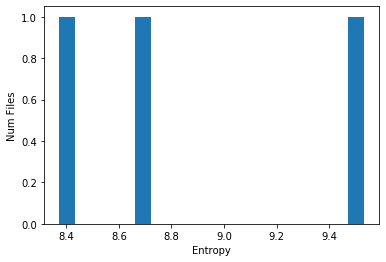

In [ ]:
# Create a histogram of the entropy distribution
plt.hist(LIB_corpus_entropies, bins = 20)
plt.ylabel("Num Files")
plt.xlabel("Entropy")
plt.show()

# Albergate as running example

In [ ]:
path = Path('../benchmarking/data/traceability/raw/Albergate_semeru_format'); path

PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format')

In [ ]:
system_name = "albergate"

In [ ]:
req_fns = sorted((path/'requirements').glob("*.txt"))
src_fns = sorted((path/'source_code').glob("*.java"))
req_fns[:5], src_fns[:5]

([PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-01.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-02.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-03.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-GES-04.txt'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/requirements/F-PRE-01.txt')],
 [PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AggiungiBeneServizio.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AggiungiSoggiornante.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AskChiudiConto.java'),
  PosixPath('../benchmarking/data/traceability/raw/Albergate_semeru_format/source_code/AskChiudiSingoloConAgenzia.java'),
  PosixPath('..

In [ ]:
output = Path('/tf/data/')
all_fns = ",".join(map(str, req_fns + src_fns))

This BPE model should really be trained across all of the traceability systems when performing the re

In [ ]:
sp.SentencePieceTrainer.train(f'--input={all_fns} --model_prefix={output / system_name} --hard_vocab_limit=false')

True

In [ ]:
spm = sp.SentencePieceProcessor()
spm.Load(f"{output / system_name}.model")

True

In [ ]:
spm.EncodeAsPieces("this is a test, public static void main")

['▁this',
 '▁i',
 's',
 '▁a',
 '▁',
 'tes',
 't',
 ',',
 '▁pu',
 'blic',
 '▁sta',
 'tic',
 '▁vo',
 'id',
 '▁ma',
 'in']

## Get countings

In [ ]:
def get_docs(fns, spm):
    docs = []
    for fn in fns:
        with open(fn, encoding="ISO-8859-1") as f:
            docs.append(spm.EncodeAsPieces(f.read()))
    
    return docs

In [ ]:
def get_counters(docs):
    doc_cnts = []
    for doc in docs:
        cnt = Counter()
        for tok in doc:
            cnt[tok] += 1
            
        doc_cnts.append(cnt)
            
    return doc_cnts

In [ ]:
req_docs = get_docs(req_fns, spm)
src_docs = get_docs(src_fns, spm)

In [ ]:
req_cnts = get_counters(req_docs)
src_cnts = get_counters(src_docs)

In [ ]:
req_cnts[0].most_common(10)

[(':', 13),
 ('▁', 13),
 ('.', 11),
 ('i', 7),
 ('▁di', 7),
 ("'", 6),
 ('▁stanza', 6),
 ('à', 6),
 ('▁F', 5),
 ('▁o', 5)]

In [ ]:
src_cnt[0].most_common(10)

[('▁', 161),
 ('_', 137),
 ('.', 110),
 ('(', 105),
 (',', 83),
 (');', 82),
 ('onstrain', 48),
 ('▁=', 46),
 (')', 44),
 ('▁1,', 40)]

In [ ]:
len(req_cnts), len(src_cnts)

(17, 55)

## Generate a distribution from list of frequencies

In [ ]:
def get_dist(cnt):
    sz = sum(cnt.values())
    max_len = len(max(list(cnt), key=len))
    alphabet = []
    ps = []
    for tok in cnt:
        alphabet.append(tok)
        ps.append(cnt[tok] / sz)
    
    return dit.ScalarDistribution(alphabet, ps)

## _Shared_ Self-Information

This is **NOT** Mutual Information, this is the amount of self information contains in the shared tokens of the two corpora.

In [ ]:
def shared_entropy(x_cnt, y_cnt):
    overlap = list(set(x_cnt) & set(y_cnt))
    z_cnt = Counter({k: (x_cnt + y_cnt).get(k, 0) for k in overlap})
    
    return dit.shannon.entropy(get_dist(z_cnt))

In [ ]:
shared_entropy(full_req_cnt, full_src_cnt)

6.045348529909803

# SCRAP CODE

In [ ]:
req_set = set(req_cnt)
src_set = set(src_cnt)

In [ ]:
z = req_set.intersection(src_set)

In [ ]:
len(z)

535

In [ ]:
sz = sum(req_cnt.values())

In [ ]:
sz

6617

In [ ]:
set_docs = [set(doc) for doc in req_docs]

In [ ]:
alphabets = []
for doc in zip(*set_docs):
    alphabets.append(doc)

In [ ]:
alphabets = []
ps = []
for tok in req_cnt:
    ps.append(req_cnt[tok] / sz)

In [ ]:
sum(ps)

0.999999999999995

In [ ]:
alphabets

[('it',
  'it',
  'it',
  '▁supplemento',
  '▁due',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  'it',
  '▁telefonica',
  '▁supplemento',
  'it',
  'it'),
 ('a',
  'a',
  'a',
  'it',
  'it',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'a',
  'it',
  'it',
  'a',
  'a'),
 ('▁collegat',
  '▁collegat',
  '▁collegat',
  'a',
  'a',
  '▁collegat',
  '▁collegat',
  '▁considerat',
  '▁collegat',
  '▁collegat',
  '▁ristorante',
  '▁rend',
  'tabili',
  'a',
  'a',
  '▁collegat',
  '8'),
 ('atore',
  'metter',
  'atore',
  '▁collegat',
  '▁collegat',
  'ua',
  'atore',
  '▁collegat',
  'atore',
  'ua',
  '▁scelta',
  'ì',
  '▁collegat',
  '▁collegat',
  '▁collegat',
  '▁tel',
  '▁collegat'),
 ('▁stanza',
  '▁nel',
  '▁stanza',
  'volger',
  'ua',
  'atore',
  '▁stanza',
  'ua',
  '▁stanza',
  '▁nel',
  '▁collegat',
  '▁collegat',
  '▁stanza',
  'atore',
  '▁stanza',
  '▁l',
  'ua'),
 ('▁base',
  '▁dispos',
  '▁base',
  '▁stanza',
  'atore',
  '▁stanza',
  '▁viene',
  'atore

In [ ]:
d = dit.ScalarDistribution(set_docs, ps)

InvalidDistribution: Unequal lengths for `pmf` and `outcomes`

In [ ]:
dit.shannon.entropy(d)

8.25790699335952

In [ ]:
alphabet = []
ps = []
for tok in req_cnt:
    alphabet.append((tok,))
    ps.append(req_cnt[tok] / sz)

In [ ]:
print(alphabet)

[('▁Requisito',), ('▁numero',), (':',), ('▁F',), ('-',), ('G',), ('ES',), ('-01',), ('▁Tipo',), ('unzional',), ('e',), ('▁',), ('Gestione',), ('▁de',), ('i',), ('▁prezz',), ('▁delle',), ('▁camere',), ('.',), ('Descrizione',), ('Per',), ('▁o',), ('gni',), ('▁camera',), ('▁deve',), ('▁essere',), ('▁possibile',), ('▁stabili',), ('re',), ('▁il',), ('▁suo',), ('▁prezzo',), ('▁base',), ('Q',), ('uesto',), ('▁imposta',), ('bile',), ('▁dal',), ('▁gestore',), ('▁dell',), ("'",), ('albergo',), ('▁qual',), ('volta',), ('egli',), ('▁lo',), ('▁ri',), ('tenga',), ('▁opportuno',), ('▁Se',), ('▁si',), ('▁desidera',), ('▁modificare',), ('▁di',), ('▁una',), ('▁stanza',), ('▁che',), ('▁in',), ('▁quel',), ('▁momento',), ('▁risulta',), ('▁occupata',), (',',), ('▁sistema',), ('▁dovr',), ('à',), ('▁avvisa',), ('▁l',), ('oper',), ('atore',), ('▁con',), ('▁un',), ('▁messaggio',), ('▁per',), ('▁evi',), ('tare',), ('▁cliente',), ('▁la',), ('menti',), ('▁non',), ('▁aver',), ('pagato',), ('▁quanto',), ('▁pa',), ('

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
dit.shannon.entropy(d)

8.25790699335952

In [ ]:
def get_dist(cnt):
    sz = sum(cnt.values())
    max_len = len(max(list(cnt), key=len))
    alphabet = []
    ps = []
    for tok in cnt:
        alphabet.append((tok,))
        ps.append(cnt[tok] / sz)
    
    return dit.Distribution(alphabet, ps)

In [ ]:
dit.Distribution?

In [ ]:
dit.shannon.entropy(get_dist(req_cnt))

8.25790699335952

In [ ]:
dit.shannon.entropy(get_dist(src_cnt))

8.005993952354078

In [ ]:
all_cnt = req_cnt + src_cnt

In [ ]:
all_cnt.most_common(10)

[('▁', 5135),
 ('.', 5059),
 ('(', 3461),
 (');', 3018),
 (',', 2454),
 ('_', 2107),
 ('onstrain', 1671),
 ('▁=', 1664),
 ('▁{', 1438),
 ('▁}', 1438)]

In [ ]:
list(map(lambda x: (x,), list(req_toks)))

[('▁Requisito',),
 ('▁numero',),
 (':',),
 ('▁F',),
 ('-',),
 ('G',),
 ('ES',),
 ('-01',),
 ('▁Tipo',),
 (':',),
 ('▁F',),
 ('unzional',),
 ('e',),
 ('▁Requisito',),
 (':',),
 ('▁',),
 ('Gestione',),
 ('▁de',),
 ('i',),
 ('▁prezz',),
 ('i',),
 ('▁delle',),
 ('▁camere',),
 ('.',),
 ('▁',),
 ('Descrizione',),
 (':',),
 ('▁',),
 ('Per',),
 ('▁o',),
 ('gni',),
 ('▁camera',),
 ('▁deve',),
 ('▁essere',),
 ('▁possibile',),
 ('▁stabili',),
 ('re',),
 ('▁il',),
 ('▁suo',),
 ('▁prezzo',),
 ('▁base',),
 ('.',),
 ('▁',),
 ('Q',),
 ('uesto',),
 ('▁prezzo',),
 ('▁deve',),
 ('▁essere',),
 ('▁imposta',),
 ('bile',),
 ('▁dal',),
 ('▁gestore',),
 ('▁dell',),
 ("'",),
 ('albergo',),
 ('▁o',),
 ('gni',),
 ('▁qual',),
 ('▁',),
 ('volta',),
 ('▁',),
 ('egli',),
 ('▁lo',),
 ('▁ri',),
 ('tenga',),
 ('▁opportuno',),
 ('.',),
 ('▁Se',),
 ('▁si',),
 ('▁desidera',),
 ('▁modificare',),
 ('▁il',),
 ('▁prezzo',),
 ('▁base',),
 ('▁di',),
 ('▁una',),
 ('▁stanza',),
 ('▁che',),
 ('▁in',),
 ('▁quel',),
 ('▁momento',),
 

In [ ]:
dit.shannon.mutual_information(get_dist(all_cnt), list(map(lambda x: (x,), list(req_cnt))), list(map(lambda x: (x,), list(src_cnt))))

ditException: `rvs` contains invalid random variables, [('▁Requisito',), ('▁numero',), (':',), ('▁F',), ('-',), ('G',), ('ES',), ('-01',), ('▁Tipo',), ('unzional',), ('e',), ('▁',), ('Gestione',), ('▁de',), ('i',), ('▁prezz',), ('▁delle',), ('▁camere',), ('.',), ('Descrizione',), ('Per',), ('▁o',), ('gni',), ('▁camera',), ('▁deve',), ('▁essere',), ('▁possibile',), ('▁stabili',), ('re',), ('▁il',), ('▁suo',), ('▁prezzo',), ('▁base',), ('Q',), ('uesto',), ('▁imposta',), ('bile',), ('▁dal',), ('▁gestore',), ('▁dell',), ("'",), ('albergo',), ('▁qual',), ('volta',), ('egli',), ('▁lo',), ('▁ri',), ('tenga',), ('▁opportuno',), ('▁Se',), ('▁si',), ('▁desidera',), ('▁modificare',), ('▁di',), ('▁una',), ('▁stanza',), ('▁che',), ('▁in',), ('▁quel',), ('▁momento',), ('▁risulta',), ('▁occupata',), (',',), ('▁sistema',), ('▁dovr',), ('à',), ('▁avvisa',), ('▁l',), ('oper',), ('atore',), ('▁con',), ('▁un',), ('▁messaggio',), ('▁per',), ('▁evi',), ('tare',), ('▁cliente',), ('▁la',), ('menti',), ('▁non',), ('▁aver',), ('pagato',), ('▁quanto',), ('▁pa',), ('t',), ('ui',), ('to',), ('Input',), ('▁richiesto',), ('▁Si',), ('▁inseri',), ('identi',), ('ficato',), ('▁e',), ('▁ad',), ('▁essa',), ('▁relativo',), ('Output',), ('▁desiderat',), ('o',), ('▁Conferma',), ('▁a',), ('▁video',), ('▁della',), ('▁modifica',), ('▁avve',), ('n',), ('uta',), ('▁eventuali',), ('▁messaggi',), ('▁errore',), ('▁Cr',), ('terio',), ('▁accetta',), ('zione',), ('▁poter',), ('▁acce',), ('dere',), ('▁alla',), ('▁del',), ('▁listino',), ('▁richi',), ('a',), ('mare',), ('▁attr',), ('ave',), ('rso',), ('▁identi',), ('▁(',), ('es',), (');',), ('▁se',), ('▁richiest',), ('▁esiste',), ('▁visualizzat',), ('d',), ('errore',), ('▁sta',), ('▁fac',), ('end',), ('operazione',), ('▁rischi',), ('s',), ('▁A',), ('spetta',), ('ive',), ('▁collegat',), ('Sup',), ('ervi',), ('sione',), ('▁gestione',), ('▁stanze',), ('▁Requisit',), ('SO',), ('-04',), ('-05',), ('▁Sta',), ('▁Re',), ('le',), ('ase',), ('▁Pri',), ('ori',), ('▁Stabil',), ('it',), ('▁L',), ('llo',), ('▁compren',), ('C',), ('ategoria',), ('inale',), ('▁2',), ('Richiest',), ('▁P',), ('ien',), ('▁S',), ('oftware',), ('▁Ver',), ('▁2.',), ('1',), ('▁Data',), ('▁0',), ('4',), ('/04/',), ('1998',), ('▁Comp',), ('il',), ('ato',), ('▁da',), ('▁Ma',), ('rt',), ('ini',), ('▁R',), ('ob',), ('erto',), ('▁Not',), ('-02',), ('▁servizi',), ('▁spes',), ('▁extra',), ('▁Il',), ('metter',), ('▁dispos',), ('izione',), ('utente',), ('▁le',), ('▁f',), ('▁necessari',), ('▁D',), ('ovr',), ('▁qu',), ('indi',), ('▁visualizzare',), ('▁apportare',), ('▁modifiche',), ('▁nuove',), ('▁voci',), ('r',), ('▁an',), ('che',), ('▁prevista',), ('▁camp',), ('▁"',), ('j',), ('oll',), ('y',), ('"',), ('▁gesti',), ('ra',), ('è',), ('ven',), ('iente',), ('▁prevede',), ('▁specifica',), ('Dati',), ('▁bene',), ('▁servizio',), ('▁int',), ('▁effettuat',), ('▁complet',), ('▁codice',), ('▁c',), ('▁ritorn',), ('er',), ('▁nel',), ('▁cas',), ('▁nessuna',), ('▁corrispondenza',), ('▁sia',), ('▁verificat',), ('▁altri',), ('▁rest',), ('uir',), ('▁i',), ('▁dati',), ('▁relativ',), ('▁al',), ('▁possibil',), ('▁modificar',), ('ne',), ('▁offert',), ('2',), ('▁V',), ('inc',), ('enti',), ('▁Pa',), ('ola',), ('-03',), ('▁archivio',), ('▁storico',), ('▁clienti',), ('▁tenere',), ('▁alcuni',), ('▁tutt',), ('anno',), ('uccessiv',), ('▁quell',), ('▁soggiorno',), ('▁gi',), ('present',), ('▁nell',), ('elenco',), ('▁dovranno',), ('▁aggiornati',), ('▁Nel',), ('l',), ('\x92',), ('archivio',), ('▁sa',), ('ranno',), ('▁inseriti',), ('▁nome',), ('▁cognome',), ('▁indirizzo',), ('ultim',), ('lui',), ('▁De',), ('ve',), ('ltre',), ('▁recuperare',), ('▁conten',), ('uti',), ('ch',), ('é',), ('alberg',), ('▁possa',), ('▁informazioni',), ('utili',), ('quals',), ('▁ne',), ('▁ab',), ('bia',), ('▁necessit',), ('▁I',), ('rit',), ('iene',), ('util',), ('alva',), ('▁verr',), ('▁pres',), ('▁dall',), ('Aggiornamento',), ('▁devo',), ('no',), ('▁dura',), ('▁almen',), ('▁fin',), ('▁fine',), ('▁seguente',), ('▁inserimento',), ('▁all',), ('ultimo',), ('oter',), ('▁man',), ('tenere',), ('▁cont',), ('atto',), ('▁pi',), ('ù',), ('▁rec',), ('▁pro',), ('m',), ('uove',), ('▁pub',), ('blic',), ('izzare',), ('▁stagione',), ('nn',), ('▁10',), ('▁M',), ('ene',), ('gh',), ('atte',), ('▁Configurazione',), ('▁op',), ('zioni',), ('▁Alcun',), ('▁parametri',), ('▁utilizza',), ('volger',), ('▁attiv',), ('▁stat',), ('▁realizza',), ('te',), ('ci',), ('ò',), ('▁configura',), ('▁alle',), ('▁esi',), ('genz',), ('c',), ('ura',), ('mente',), ('compar',), ('ire',), ('ono',), ('▁seguenti',), ('▁impost',), ('azioni',), ('▁date',), ('▁inizio',), ('▁vari',), ('▁stagionalit',), ('▁sconti',), ('▁riduzioni',), ('▁effettuare',), ('▁neonati',), ('▁bambini',), ('▁durata',), ('▁massim',), ('▁pu',), ('▁restar',), ('▁bloccata',), ('▁supplemento',), ('▁costo',), ('uno',), ('▁scatto',), ('▁telefonico',), ('▁configurazione',), ('▁riten',), ('ute',), ('▁opportun',), ('▁inf',), ('▁sull',), ('rea',), ('▁comp',), ('enza',), ('E',), ('▁viene',), ('▁previst',), ('conto',), ('tale',), ('▁apparir',), ('▁chi',), ('ar',), ('amente',), ('▁calcolo',), ('▁conto',), ('▁finale',), ('▁su',), ('▁stampa',), ('▁Permette',), ('▁maggiore',), ('ibilit',), ('PR',), ('▁So',), ('spes',), ('O',), ('pzion',), ('ale',), ('▁15',), ('▁Ricerca',), ('▁disponibili',), ('▁elenc',), ('are',), ('▁periodo',), ('▁vi',), ('▁esatta',), ('▁mostrat',), ('▁disponibilit',), ('▁mod',), ('▁grado',), ('▁fornir',), ('▁sug',), ('ger',), ('imento',), ('▁come',), ('▁sposta',), ('▁rid',), ('men',), ('sion',), ('▁permanenza',), ('▁Tal',), ('▁inter',), ('vall',), ('▁tempo',), ('pre',), ('sso',), ('▁giorni',), ('corr',), ('▁tra',), ('▁due',), ('▁Ad',), ('empi',), ('5/0',), ('7',), ('/1998',), ('▁1',), ('1/0',), ('▁im',), ('plica',), ('▁7',), ('▁liber',), ('azione',), ('▁giorno',), ('2/0',), ('▁m',), ('atti',), ('na',), ('▁partire',), ('▁res',), ('▁disponibile',), ('▁altre',), ('▁prenotazioni',), ('▁La',), ('▁ricerca',), ('▁vincol',), ('▁bloccate',), ('▁assegnate',), ('▁commissionate',), ('▁agenzie',), ('▁viaggi',), ('▁fornit',), ('agenzia',), ('▁prima',), ('▁co',), ('pri',), ('▁commissionament',), ('ua',), ('ndo',), ('▁permett',), ('▁alcun',), ('▁prenotazione',), ('▁potr',), ('Periodo',), ('▁scelto',), ('tab',), ('ella',), ('▁riassum',), ('▁Dat',), ('▁ritornare',), ('▁evidenz',), ('tramite',), ('▁agenzia',), ('ed',), ('▁eventual',), ('▁Pr',), ('on',), ('ta',), ('▁verifica',), ('4.',), ('0',), ('▁16/04/',), ('▁Prenotazione',), ('▁parte',), ('▁effettua',), ('iare',), ('▁veng',), ('▁ha',), ('b',), ('itu',), ('mi',), ('co',), ('▁assegna',), ('gli',), ('rtar',), ('▁stata',), ('▁assegnata',), ('È',), ('conosc',), ('ere',), ('▁poss',), ('▁soddisfa',), ('disponibilit',), ('▁letto',), ('▁aggiuntivo',), ('▁vis',), ('/',), (').',), ('▁In',), ('▁forniti',), ('▁stess',), ('vedi',), ('egistra',), ('▁blocca',), ('ggio',), ('mento',), (')',), ('▁accord',), ('▁Do',), ('po',), ('▁accettata',), ('▁sott',), ('tta',), ('questo',), ('▁qua',), ('ro',), ('▁g',), ('ener',), ('▁albergo',), ('mplic',), ('▁ovv',), ('ero',), ('▁ved',), ('▁commissionata',), ('▁min',), ('imo',), ('▁provveder',), ('acco',), ('gua',), ('▁allo',), ('rganizza',), ('vo',), ('▁fatt',), ('▁ma',), ('▁real',), ('▁arriv',), ('▁support',), ('▁occupate',), ('-06',), ('▁2.0',), ('▁3',), ('0/0',), ('3',), ('▁Da',), ('nzi',), ('▁Fr',), ('ance',), ('sca',), ('Not',), ('▁rim',), ('arr',), ('▁fissat',), ('▁Tra',), ('▁invia',), ('accia',), ('▁comprender',), ('▁tr',), ('oppo',), ('▁ci',), ('▁informa',), ('▁ritardo',), ('▁dov',), ('uto',), ('▁contratt',), ('empo',), ('▁opp',), ('ure',), ('▁soggiorna',), ('primo',), ('▁r',), ('innova',), ('ment',), ('secondo',), ('▁cancellare',), ('Un',), ('▁arriva',), ('▁caparra',), ('▁passa',), ('▁aggiornat',), ('anti',), ('passata',), (';',), ('▁avvis',), ('▁pagamento',), ('▁controll',), ('▁riman',), ('ga',), ('▁lu',), ('ngo',), ('ando',), ('▁far',), ('▁pote',), ('ziali',), ('nsione',), ('termin',), ('ati',), ('▁period',), ('ebb',), ('▁tal',), ('▁risult',), ('eranno',), ('▁que',), ('▁sol',), ('vent',), ('giung',), ('ntro',), ('▁data',), ('▁concordat',), ('st',), ('pu',), ('lazione',), ('commissionamento',), ('nformazioni',), ('data',), ('▁do',), ('▁considerat',), ('▁commissione',), ('▁verificar',), ('▁loro',), ('▁effettivo',), ('▁anc',), ('ora',), ('▁esse',), ('ino',), ('esce',), ('▁occupar',), ('▁Cancellazione',), ('▁dai',), ('▁disd',), ('▁era',), ('orneranno',), ('annulla',), ('etta',), ('▁precedente',), ('▁stabilit',), ('▁scadenza',), ('▁No',), ('min',), ('ativo',), ('▁lascia',), ('▁Modifica',), ('▁prenota',), ('▁elimina',), ('▁corrispond',), ('▁esistente',), ('▁conferma',), ('▁cancella',), ('▁coinvol',), ('▁cambiat',), ('▁contra',), ('rio',), ('▁annulla',), ('seguente',), ('▁aggiornamento',), ('▁inesistente',), ('osi',), ('1.',), ('Colo',), ('mb',), ('ari',), ('nd',), ('▁registrat',), ('atura',), ('lmente',), ('▁aggiorna',), ('▁nomi',), ('▁tipo',), ('▁vuo',), ('▁cerca',), ('Effettuat',), ('9',), ('RIS',), ('▁ristorante',), ('▁estern',), ('tabilit',), ('mmediat',), ('▁normale',), ('▁soggiornanti',), ('hotel',), ('port',), ('ate',), ('▁singol',), ('▁scelta',), ('▁men',), ('▁fiss',), ('ing',), ('▁consumate',), ('▁ricev',), ('▁consuma',), ('numero',), ('▁persone',), ('▁bevande',), ('alit',), ('▁Stampa',), ('equisito',), ('▁forni',), ('sce',), ('▁ristorazione',), ('attiv',), ('9/0',), ('lli',), ('ria',), ('rrivo',), ('All',), ('▁risal',), ('▁and',), ('▁occupare',), ('▁proced',), ('▁fo',), ('se',), ('▁b',), ('sito',), ('▁fa',), ('▁nuovo',), ('▁richied',), ('▁aggiunger',), ('loro',), ('▁occupan',), ('certa',), ('nto',), ('con',), ('p',), ('iti',), ('▁soggiorn',), ('▁persona',), ('li',), ('fa',), ('colta',), ('tivi',), ('ragazz',), ('▁soggiornano',), ('ulti',), ('▁pensionamento',), ('▁permette',), ('▁divers',), ('▁distingu',), ('▁rie',), ('nt',), ('▁categori',), ('▁rend',), ('applica',), ('▁cos',), ('ì',), ('▁utilizzate',), ('▁dato',), ('appe',), ('lla',), ('tivo',), ('▁occupanti',), ('chiesto',), ('▁ripet',), ('▁annullar',), ('la',), ('▁p',), ('ulter',), ('iore',), ('onosc',), ('oggi',), ('ano',), ('▁Addebito',), ('valuta',), ('addebitare',), ('▁sul',), ('▁addebitar',), ('lo',), ('h',), ('▁usufrui',), ('▁quantit',), ('▁consumato',), ('▁traccia',), ('▁spesa',), ('▁poi',), ('▁recupera',), ('mmon',), ('Con',), ('tabili',), ('zza',), ('ma',), ('tic',), ('stra',), ('ordin',), ('arie',), ('fficien',), ('za',), ('▁telefonica',), ('Vis',), ('▁norma',), ('tiva',), ('▁indi',), ('ente',), ('▁tener',), ('▁scatti',), ('inizio',), ('olt',), ('▁prop',), ('rie',), ('tario',), ('addebito',), ('▁totale',), ('▁telefonate',), ('▁central',), ('▁comun',), ('icare',), ('▁telefonata',), ('nte',), ('▁addebito',), ('per',), ('ibili',), ('▁controlla',), ('▁ric',), ('ava',), ('van',), ('aggio',), ('▁dispo',), ('▁quest',), ('98',), ('interfacc',), ('▁questa',), ('▁commissionato',), ('get',), ('mulat',), ('cola',), ('▁Calcolo',), ('▁comple',), ('ssivo',), ('▁Al',), ('▁telefoniche',), ('▁3.',), ('▁parzial',), ('▁vo',), ('ce',), ('▁so',), ('rain',), ('dic',), ('ata',), ('totali',), ('informazion',), ('inter',), ('▁pernottament',), ('▁compre',), ('▁4',), ('▁-',), ('unica',), ('▁separato',), ('▁gli',), ('▁mo',), ('▁lasciare',), ('▁anticip',), ('▁risp',), ('etto',), ('▁esclus',), ('versat',), ('dati',), ('consiste',), ('▁numeri',), ('▁visualizzazione',), ('▁accumulat',), ('debito',), ('▁forma',), ('N',), ('U',), ('M',), ('MM',), ('ersone',), ('#',), ('ti',), ('###',), ('▁Scatti',), ('▁tel',), ('▁PARZIALE',), ('#####',), ('▁Desc',), ('▁...',), ('--------------',), ('---------------',), ('TO',), ('TAL',), ('#######',), ('▁pernottamento',), ('▁riporta',), ('hi',), ('▁cambio',), ('▁desider',), ('▁costr',), ('sto',), ('▁cambiare',), ('▁stru',), ('▁affinch',), ('Numero',), ('▁nuova',), ('▁indic',), ('▁occupa',), ('▁status',), ('▁ac',), ('▁riferi',), ('▁precede',), ('nza',), ('▁cambia',), ('8',)], set() 0.

In [ ]:
req_sz = sum(req_cnt.values())
src_sz = sum(src_cnt.values())

In [ ]:
all_cnt = req_cnt + src_cnt
sz = sum(all_cnt.values())
alphabet = []
ps = []
for tok in all_cnt:
    alphabet.append((tok, tok))
    ps.append(all_cnt[tok] / sz)

In [ ]:
alphabet = []
ps = []
for req_tok, src_tok in req_cnt:
    alphabet.append((req_tok))
    ps.append((req_cnt[req_tok] / req_sz, src_cnt[src_tok] / src_sz))

In [ ]:
len(alphabet), len(ps)

(949, 2490)

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
req_alphabet = []
src_ps = []
for tok in req_cnt:
    alphabet.append((tok, "a"))
    src_ps.append(req_cnt[tok] / sz)

In [ ]:
d = dit.Distribution(alphabet, ps)

In [ ]:
d.rvs

[[0], [1]]

In [ ]:
d.alphabet

(('!',
  '!=',
  '"',
  '")',
  '"+',
  '",',
  '","',
  '","",',
  '",1',
  '",2',
  '",3',
  '",4',
  '#',
  '###',
  '#####',
  '#######',
  '%',
  '&',
  "'",
  '\'"',
  '\':"',
  '(',
  '("',
  '(""',
  '("")',
  '(""))',
  '(""+',
  '("",',
  '("","","',
  '("",1',
  '("",2',
  '("",3',
  '("",4',
  '()',
  '())',
  '()))',
  '())))',
  '()));',
  '())*',
  '()),',
  '()).',
  '());',
  '()+',
  '()+"',
  '()+"."',
  '()+"."+',
  '()+1)',
  '(),',
  '();',
  '(0',
  '(10,',
  '(15,',
  '(25',
  '(350,',
  '(4,1)',
  ')',
  '))',
  ')))',
  ')));',
  '))+',
  ')).',
  '));',
  ')+"',
  ').',
  ');',
  '*',
  '***************',
  '+',
  '+"',
  '+".',
  '+(',
  '++',
  '+1',
  '+1))',
  ',',
  ',"',
  ',"","","',
  ',0,0,4,',
  ',0.0,0.0,5,',
  ',1.0,0.0,',
  ',1.0,1.0,',
  '-',
  '--',
  '--------------',
  '---------------',
  '-01',
  '-02',
  '-03',
  '-04',
  '-05',
  '-06',
  '-1)',
  '-1;',
  '-1]',
  '-1]+"',
  '->',
  '.',
  '/',
  '/04/',
  '/1998',
  '0',
  '0)',
  '0,',

In [ ]:
len(d.alphabet)

1

In [ ]:
d.rvs

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138]

In [ ]:
dit.shannon.mutual_information(d, [0], [1], rv_mode = 'indexes')

8.230229937133148

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.conv.ipynb.
Converted 0.2_mgmnt.db.mongo.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.4_mgmnt.corpus.ipynb.
Converted 0.5_mgmnt.prep.traceability.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info-[inspect].ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 3.0_mining.unsupervised.traceability.ida.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach[cisco].ipynb.
Converted 3.3_mining.unsupervised.traceability.eval.ipynb.
Convert

In [ ]:
! nbdev_build_lib

Converted 0.0_mgmnt.prep.i.ipynb.
Converted 0.1_mgmnt.prep.conv.ipynb.
Converted 0.2_mgmnt.db.mongo.ipynb.
Converted 0.3_mgmnt.prep.bpe.ipynb.
Converted 0.4_mgmnt.corpus.ipynb.
Converted 0.5_mgmnt.prep.traceability.ipynb.
Converted 0.6_mgmnt.prep.nltk.ipynb.
Converted 1.0_exp.i.ipynb.
Converted 1.1_exp.info-[inspect].ipynb.
Converted 1.1_exp.info.ipynb.
Converted 1.2_exp.csnc.ipynb.
Converted 1.3_exp.csnc_python.ipynb.
Converted 2.0_repr.i.ipynb.
Converted 2.1_repr.codeberta.ipynb.
Converted 2.1_repr.roberta.train.ipynb.
Converted 2.2_repr.roberta.eval.ipynb.
Converted 2.3_repr.word2vec.train.ipynb.
Converted 2.6_repr.word2vec.eval.ipynb.
Converted 2.7_repr.distmetrics.ipynb.
Converted 3.0_mining.unsupervised.traceability.ida.ipynb.
Converted 3.1_mining.unsupervised.traceability.eda.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach.ipynb.
Converted 3.2_mining.unsupervised.traceability.approach[cisco].ipynb.
Converted 3.3_mining.unsupervised.traceability.eval.ipynb.
Convert